In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.iolib import SimpleTable
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, het_white
from statistics import Arima
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
from scipy.stats.stats import kurtosis, skew
from IPython.core.display import display
from patsy import dmatrices

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20

In [2]:
df = pd.read_csv('./data/RTSI-dailyhistory-ru.csv', parse_dates=['Date'], index_col='Date', dayfirst=True)
series = df[('2009-01' < df.index) & (df.index < '2020-02')].Close
series = series.resample('1m').last()

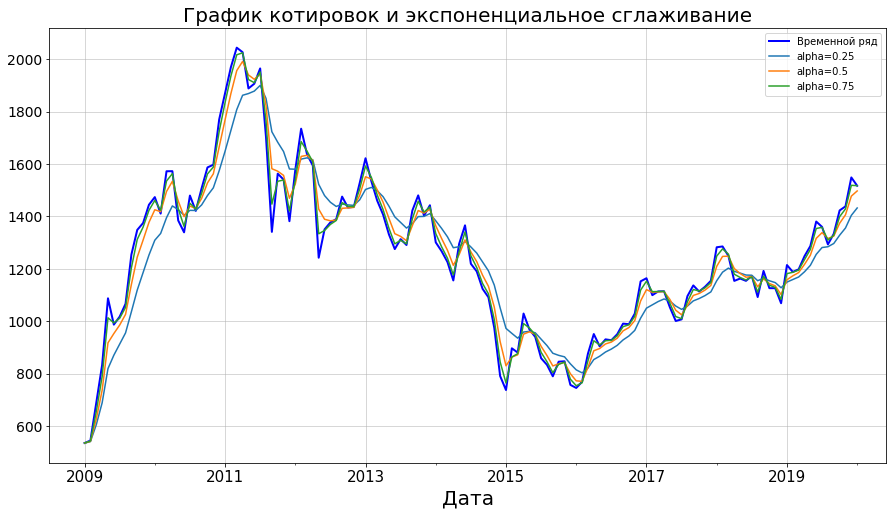

In [3]:
ax = series.plot(legend=True, color='blue', label='Временной ряд', linewidth=2)
for alpha in [.25, .5, .75]:
    series.ewm(alpha=alpha).mean().plot(ax=ax, label=f'alpha={alpha}', legend=True)
ax.set_title('График котировок и экспоненциальное сглаживание')
ax.set_xlabel('Дата');
ax.set_xlim('2008-07', '2020-06')
del ax

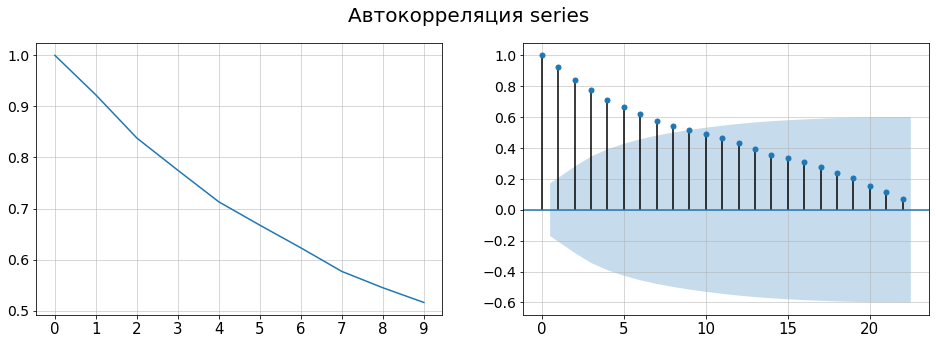

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
fig.suptitle('Автокорреляция series')

ax1.set_xticks(np.linspace(0, 10, 11))
ax1.plot(acf(series, fft=False)[:10])

plot_acf(series, ax=ax2, title='');

plt.show();
del fig, ax1, ax2

### Тест Фуллера на стационарность ряда

In [5]:
fuller_test = adfuller(series)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test

Ряд нестационарен


# Составление тренда 

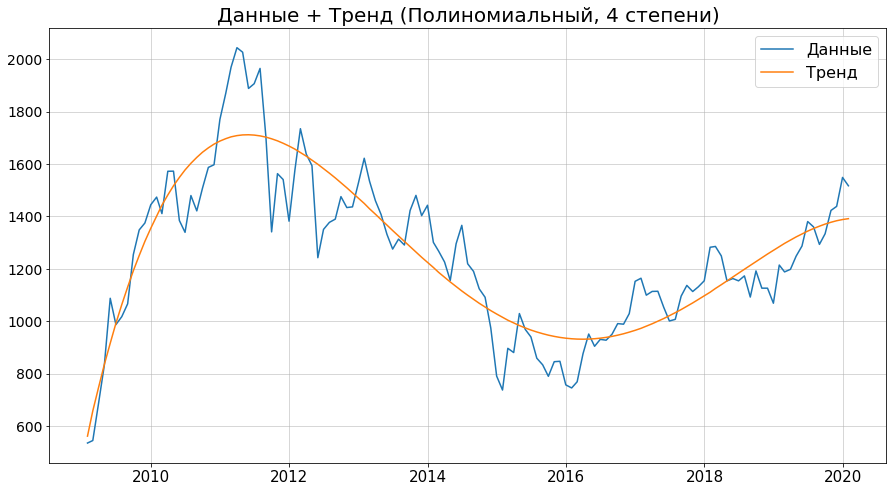

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     138.2
Date:                Sun, 15 Mar 2020   Prob (F-statistic):           1.86e-45
Time:                        18:13:28   Log-Likelihood:                -837.17
No. Observations:                 133   AIC:                             1684.
Df Residuals:                     128   BIC:                             1699.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        561.3528     55.398     10.133      0.000     451.739     670.967
x1            99.1642      5.862     16.917      0.000      87.565     110.763
x2            -2.7296      0.182    -15.033      0.000      -3.089      -2.370
x3             0.0256      0.002     12.353      0.000       0.021       0.030
x4          -7.75e-05   7.78e-06     -9.961      0.000   -9.29e-05   -6.21e-05
==============================================================================
Omnibus:                        0.478   Durbin-Watson:                   0.527
Prob(Omnibus):                  0.787   Jarque-Bera (JB):                0.247
Skew:                          -0.095   Prob(JB):                        0.884
Kurtosis:                       3.092   Cond. No.                     4.92e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
pf = PolynomialFeatures(degree=4)
xp = pf.fit_transform(np.arange(series.size)[:, np.newaxis])
fitted_model = sm.OLS(series, xp).fit()

plt.title('Данные + Тренд (Полиномиальный, 4 степени)')
plt.plot(series, label='Данные')

# Значения линии тренда
# Вместо .fittedvalues можно .predict(xp)
series_trend = fitted_model.fittedvalues
series_remains = fitted_model.resid
series_remains_exog = fitted_model.model.exog

plt.plot(series_trend, label='Тренд');
plt.legend(fontsize=16)
plt.show()
display(fitted_model.summary())
del pf, xp, fitted_model

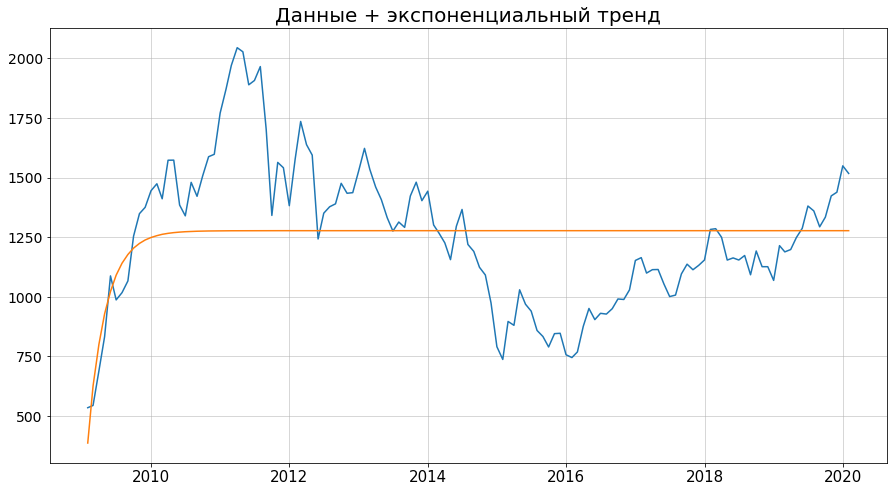

In [7]:
def func_exp(x, a, b, c):
        #c = 0
        return a * np.exp(b * x) + c

def exponential_regression (x_data, y_data):
    popt, pcov = curve_fit(func_exp, x_data, y_data, p0 = (-1, 0.01, 1))
    return func_exp(x_data, *popt)

x_data = np.arange(0, series.size) 
y_data = series
plt.title('Данные + экспоненциальный тренд')
plt.plot(series)
plt.plot(pd.Series(exponential_regression(x_data, y_data), index=series.index));

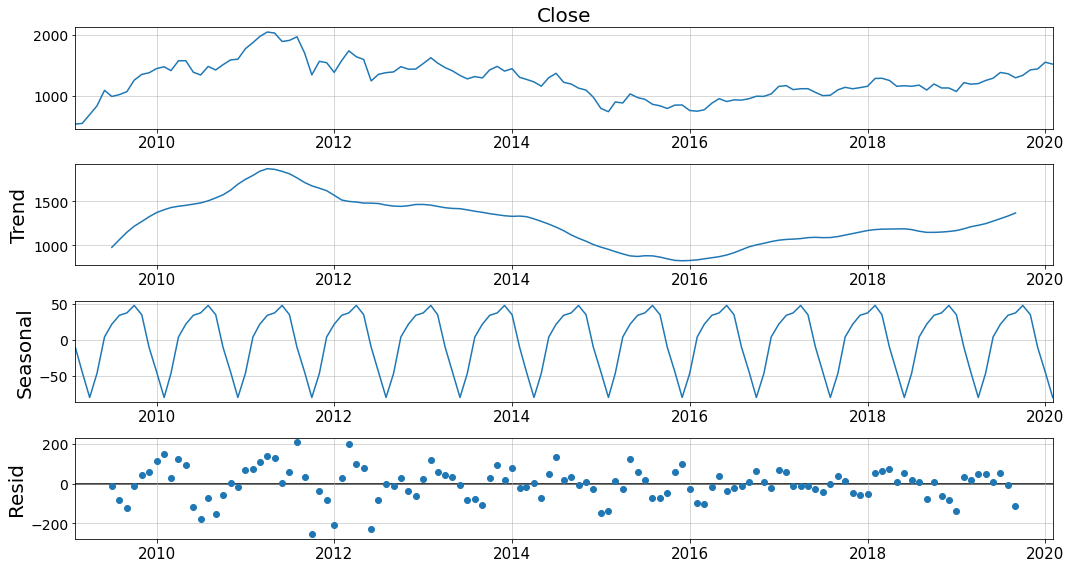

In [8]:
sm.tsa.seasonal_decompose(series.interpolate(), period=10).plot();

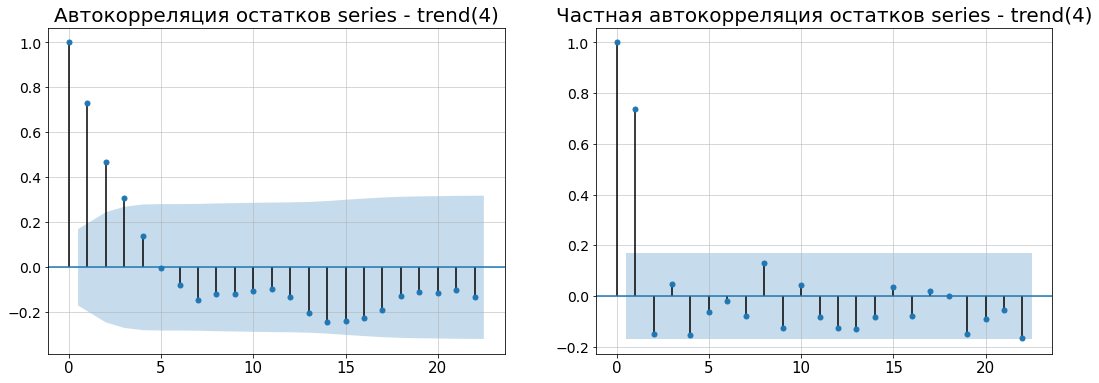

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
plot_acf(series_remains, title='Автокорреляция остатков series - trend(4)', ax=ax1);
plot_pacf(series_remains, title='Частная автокорреляция остатков series - trend(4)', ax=ax2);

In [10]:
# Лучшие pdq - 4, 0, 4
model = ARIMA(series_remains, order=(4, 0, 4))
arima_by_series_remains = model.fit()
display(arima_by_series_remains.summary())

del model

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  133
Model:                     ARMA(4, 4)   Log Likelihood                -774.466
Method:                       css-mle   S.D. of innovations             79.336
Date:                Sun, 15 Mar 2020   AIC                           1568.932
Time:                        18:13:31   BIC                           1597.835
Sample:                    01-31-2009   HQIC                          1580.677
                         - 01-31-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4286      3.122      0.137      0.891      -5.691       6.548
ar.L1.y        0.2242      0.109      2.054      0.040       0.010       0.438
ar.L2.y        0.9350      0.068     13.823      0.000       0.802       1.068
ar.L3.y        0.3193      0.091      3.510      0.000       0.141       0.498
ar.L4.y       -0.6568      0.072     -9.097      0.000      -0.798      -0.515
ma.L1.y        0.5956      0.152      3.926      0.000       0.298       0.893
ma.L2.y       -0.7338      0.108     -6.787      0.000      -0.946      -0.522
ma.L3.y       -0.9442      0.111     -8.475      0.000      -1.163      -0.726
ma.L4.y        0.0824      0.148      0.558      0.577      -0.207       0.372
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8727           -0.6394j            1.0819           -0.3994
AR.2           -0.8727           +0.6394j            1.0819            0.3994
AR.3            1.1158           -0.2365j            1.1406           -0.0332
AR.4            1.1158           +0.2365j            1.1406            0.0332
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.8390           -0.5442j            1.0000           -0.4084
MA.3           -0.8390           +0.5442j            1.0000            0.4084
MA.4           12.1423           -0.0000j           12.1423           -0.0000
-----------------------------------------------------------------------------
"""

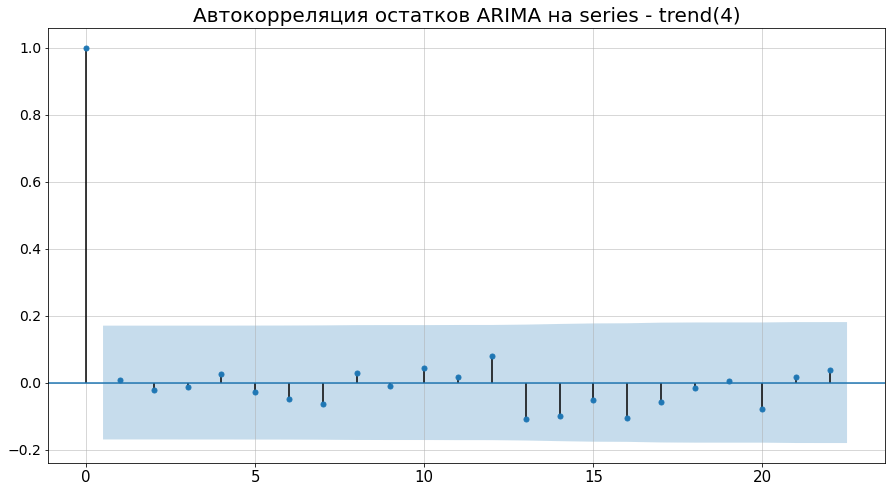

In [11]:
plot_acf(arima_by_series_remains.resid, title='Автокорреляция остатков ARIMA на series - trend(4)');

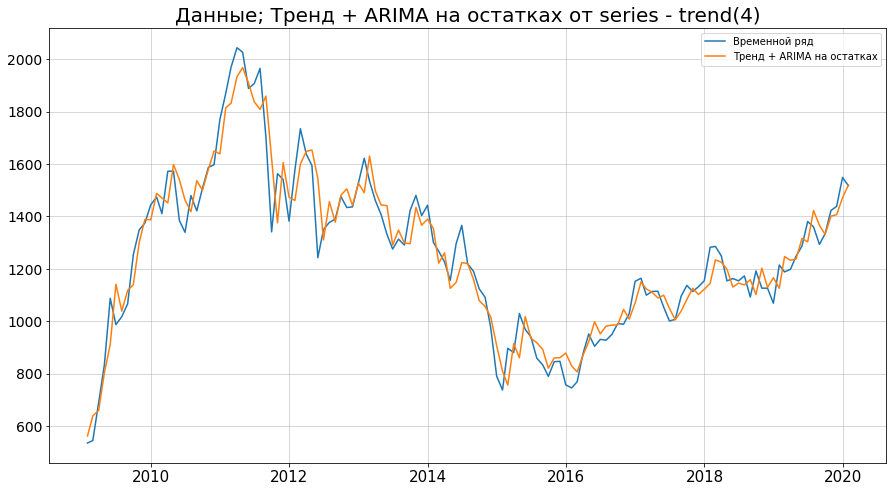

In [12]:
plt.plot(series, label='Временной ряд');
plt.plot(series_trend + arima_by_series_remains.fittedvalues, label='Тренд + ARIMA на остатках');
plt.title('Данные; Тренд + ARIMA на остатках от series - trend(4)')
plt.legend()
plt.show()

# Проверка предпосылок регрессионного анализа
#### - Нулевая средняя величина
#### - Остатки подчиняются нормальному распределению
#### - Случайный характер остатков
#### - Гомоскедастичность
#### - Отсутствие автокорреляции

## Нулевая средняя величина

In [13]:
print('Средняя величина остатков:', arima_by_series_remains.resid.mean())

Средняя величина остатков: -0.40576352477261707


## Остатки подчиняются нормальному распределению 

### На уровне значимости 0.05, нулевая гипотеза о нормальности распределения принимается

In [14]:
display(SimpleTable(
    np.array([sm.stats.stattools.jarque_bera(arima_by_series_remains.resid)]),
     ['JB', 'p-value', 'skew', 'kurtosis']
))
# p-value - вероятность неверного принятия 0-ой гипотезы о нормальности распределения

JB,p-value,skew,kurtosis
11.663434660419803,0.0029330356619095134,-0.311451321722188,4.310218392296635


In [15]:
kurt = kurtosis(arima_by_series_remains.resid)
n = arima_by_series_remains.resid.size
kurt_critical = 5*(24*n*(n-2)*(n-3)/(n+1)**2/(n+3)/(n+4))**.5
sk = skew(arima_by_series_remains.resid)
sk_critical = 3*(6*(n-1)/(n+1)/(n+3))**.5

if kurt < kurt_critical:
    print(f'Эксцесс {kurt:.4f} меньше критического {kurt_critical:.4f}')
else:
    print(f'Эксцесс {kurt:.4f} больше, либо равен критическому {kurt_critical:.4f}')

if sk < sk_critical:
    print(f'Ассиметрия {sk:.4f} меньше критического {sk_critical:.4f}')
else:
    print(f'Ассиметрия {sk:.4f} больше, либо равна критической {sk_critical:.4f}')
    
rem = arima_by_series_remains.resid
# Полученное значение сравнивается с табличными 
# С вероятностью ошибки-0.05 и длиной выборки-100 РС критерий должен быть в диапазон(4.31; 5.9)
rc = (rem.max() - rem.min()) / ((rem**2).sum()/len(rem)-1)**.5
print(f'РС критерий: {rc:.4f}')

Эксцесс 1.3102 меньше критического 2.0155
Ассиметрия -0.3115 меньше критического 0.6254
РС критерий: 5.9836


## Случайный характер остатков 

In [16]:
fuller_test = adfuller(arima_by_series_remains.resid)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test

Ряд стационарен


## Гомоскедастичность

In [17]:
het_breuschpagan(series_remains, series_remains_exog)

(20.68638425618582,
 0.00036537936914568194,
 5.893891776290757,
 0.00021915721304981443)

In [18]:
het_goldfeldquandt(series_remains, series_remains_exog)

(0.23413467743349423, 0.9999999729210513, 'increasing')

In [29]:
het_white??

In [19]:
het_white(series_remains, series_remains_exog)

(25.39451823173037,
 0.00011689961215026065,
 5.994311372305506,
 5.170011042279298e-05)

In [26]:
tmp = series.to_frame()
tmp['t'] = np.arange(tmp.size)
tmp['t2'] = tmp.t ** 2
tmp['t3'] = tmp.t ** 3
tmp['t4'] = tmp.t2 ** 2
tmp['t22'] = tmp.t2.copy()
tmp['t44'] = tmp.t4.copy()
tmp['t6'] = tmp.t3 ** 2
tmp['t8'] = tmp.t4 ** 2

tmp['a'] = tmp.t3.copy()
tmp['b'] = tmp.t4.copy()
tmp['c'] = tmp.t4 * tmp.t
tmp['d'] = tmp.t4 * tmp.t
tmp['e'] = tmp.t3 ** 2
tmp['f'] = tmp.t3 * tmp.t4
tmp['remains'] = series_remains ** 2
tmp

,Close,t,t2,t3,t4,t22,t44,t6,t8,a,b,c,d,e,f,remains
Date,,,,,,,,,,,,,,,,
2009-01-31,535.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,692.361356
2009-02-28,544.58,1,1,1,1,1,1,1,1,1,1,1,1,1,1,12821.688269
2009-03-31,689.63,2,4,8,16,4,16,64,256,8,16,32,32,64,128,3520.795772
2009-04-30,832.87,3,9,27,81,9,81,729,6561,27,81,243,243,729,2187,4.383317
2009-05-31,1087.59,4,16,64,256,16,256,4096,65536,64,256,1024,1024,4096,16384,29459.005260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30,1333.91,128,16384,2097152,268435456,16384,268435456,4398046511104,72057594037927936,2097152,268435456,34359738368,34359738368,4398046511104,562949953421312,1362.175546
2019-10-31,1422.92,129,16641,2146689,276922881,16641,276922881,4608273662721,76686282021340161,2146689,276922881,35723051649,35723051649,4608273662721,594467302491009,2037.607303
2019-11-30,1438.45,130,16900,2197000,285610000,16900,285610000,4826809000000,81573072100000000,2197000,285610000,37129300000,37129300000,4826809000000,627485170000000,3007.980421


In [28]:
f = smf.ols('remains ~ (t + t2 + t3 + t4 + t22 + t44 + t6 + t8 + a + b + c + d + e + f)', data=tmp).fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                remains   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     5.994
Date:                Sun, 15 Mar 2020   Prob (F-statistic):           5.17e-05
Time:                        18:17:40   Log-Likelihood:                -1520.6
No. Observations:                 133   AIC:                             3053.
Df Residuals:                     127   BIC:                             3071.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8665      0.859      2.173      0.032       0.167       3.566
t             10.5313      4.841      2.176      0.031       0.953      20.110
t2           127.0697     58.292      2.180      0.031      11.721     242.418
t3            -6.0859      5.365     -1.134      0.259     -16.703       4.531
t4             0.0707      0.129      0.548      0.585      -0.185       0.326
t22          127.0737     58.293      2.180      0.031      11.721     242.426
t44            0.0707      0.129      0.548      0.585      -0.185       0.326
t6            -0.0004      0.000     -2.675      0.008      -0.001   -9.22e-05
t8         -2.102e-10   6.92e-10     -0.304      0.762   -1.58e-09    1.16e-09
a             -6.0859      5.365     -1.134      0.259     -16.703       4.531
b              0.0707      0.129      0.548      0.585      -0.185       0.326
c             -0.0007      0.004     -0.190      0.849      -0.008       0.006
d             -0.0007      0.004     -0.190      0.849      -0.008       0.006
e              0.0004      0.000      1.813      0.072   -3.22e-05       0.001
f           6.756e-08   3.44e-07      0.196      0.845   -6.14e-07    7.49e-07
==============================================================================
Omnibus:                       58.945   Durbin-Watson:                   1.587
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.744
Skew:                           1.760   Prob(JB):                     1.68e-36
Kurtosis:                       7.164   Cond. No.                     3.19e+30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.91e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""